In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./model")

In [3]:
import torch
import argparse
import functools
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Optional

In [4]:
import analyze
from quant import *
from outlier import *
from eval import *
from collections import defaultdict
from pprint import pprint
from modelutils_llama import quantize_model_llama, reorder_model_llama, quantize_model_gptq_llama,  add_act_quant_wrapper_llama
from modelutils_opt import quantize_model_opt, reorder_model_opt, quantize_model_gptq_opt,  add_act_quant_wrapper_opt
from modelutils_mixtral import quantize_model_mixtral, add_act_quant_wrapper_mixtral, reorder_model_mixtral
from parallel_utils import map_layers_to_multi_gpus
from LMClass import LMClass
from eval import pattern_match
from lm_eval import tasks as lm_tasks
from lm_eval import evaluator as lm_evaluator
from datautils import *

In [5]:
torch.set_printoptions(precision=10)

In [6]:
model = torch.load("./saved/llama2-7b_quantized.pth")

In [7]:
inputs = torch.load("./saved/llama2-7b_inputs.pth")
outputs = torch.load("./saved/llama2-7b_outputs.pth")

In [8]:
input_scales = analyze.get_input_quant_param_dict(inputs)
weight_scales = analyze.get_weight_quant_param_dict(model)

# Q proj example

In [9]:
input = inputs["layers.1.self_attn.q_proj.input"][0][0]
weight = model.model.layers[1].self_attn.q_proj.weight
input_scale = input_scales["layers.1.self_attn.q_proj.input.scale"][0]
weight_scale = weight_scales["layers.1.self_attn.q_proj.scale"]

In [10]:
ex_in_scale = torch.zeros_like(input)
for i in range(input_scale.shape[1]):
  for j in range(128):
    ex_in_scale[:, 128*i+j] = input_scale[:, i]

In [11]:
ex_weight_scale = torch.zeros_like(weight)
for i in range(weight_scale.shape[1]):
  for j in range(128):
    ex_weight_scale[:, 128*i+j] = weight_scale[:, i]

In [12]:
qin = torch.round(input / ex_in_scale).to(torch.int32)

In [13]:
qw = torch.round(weight / ex_weight_scale).to(torch.int32)

In [14]:
output = torch.zeros(2048, 4096)
for i in range(int(4096/128)):
  input = qin[:, 128*i:128*(i+1)]
  weight = qw[:, 128*i:128*(i+1)]
  scale_mat = torch.matmul(input_scale[:, i].reshape(-1, 1).float(), weight_scale[:, i].reshape(1, -1).float())
  out_psum = torch.matmul(input.float(), weight.T.float()) *scale_mat
  output += out_psum

In [15]:
outputs["layers.1.self_attn.q_proj.output"][0][0]

tensor([[ 1.0556640625,  0.8720703125,  0.4868164062,  ...,
         -0.4604492188,  0.4501953125, -0.7070312500],
        [ 0.4333496094,  1.1308593750,  1.1591796875,  ...,
         -0.7026367188,  0.7138671875, -1.0390625000],
        [-0.0579528809,  0.1237182617, -0.0636596680,  ...,
         -0.2519531250,  0.2120361328, -0.3811035156],
        ...,
        [ 0.6923828125,  0.3073730469, -0.1662597656,  ...,
         -1.1923828125,  1.2744140625, -1.7070312500],
        [ 0.4426269531, -0.1181640625, -0.8208007812,  ...,
         -1.3339843750,  1.3857421875, -1.8271484375],
        [ 1.0263671875, -0.0160217285, -0.1323242188,  ...,
         -1.2792968750,  1.3037109375, -1.7617187500]], dtype=torch.float16)

In [16]:
output

tensor([[ 1.0554859638,  0.8714380860,  0.4867995381,  ...,
         -0.4613430500,  0.4500094354, -0.7079493999],
        [ 0.4331092238,  1.1303099394,  1.1592936516,  ...,
         -0.7033892274,  0.7142342925, -1.0398788452],
        [-0.0580718815,  0.1232908964, -0.0635855794,  ...,
         -0.2535985708,  0.2121106386, -0.3831257224],
        ...,
        [ 0.6922274828,  0.3071002662, -0.1662508249,  ...,
         -1.1931613684,  1.2745239735, -1.7080430984],
        [ 0.4426766932, -0.1184072569, -0.8211003542,  ...,
         -1.3333269358,  1.3855804205, -1.8256323338],
        [ 1.0260618925, -0.0164278001, -0.1323765814,  ...,
         -1.2799038887,  1.3039546013, -1.7627288103]], grad_fn=<AddBackward0>)

In [51]:
@dataclass
class ACIMDotResults:
  out: torch.Tensor
  precise_out: torch.Tensor
  pre_scale_psum_errs: List[List[int]]

def get_bit(input, bit_pos):
  input = input >> bit_pos
  return input & 1

def get_bitplane(input, bit_pos):
  mask = 1 << bit_pos
  return (input & mask) >> bit_pos

def normal_quantize(input):
  step = 16
  outval = torch.round(input/step) * step
  return outval.to(torch.int32)

def adaptive_quantize(input):
  max_val = 15

  # if input > max_val:
  #   div = torch.pow(2, torch.ceil(torch.log2(input/max_val)))
  # else:
  #   div = 1
    
  need_adjust = (input > max_val)
  div = torch.pow(2, torch.ceil(torch.log2(input/max_val)))

  # outval = torch.round(input/div) * div
  outval = torch.zeros_like(input, dtype=torch.float32)
  outval[need_adjust] = torch.round(input[need_adjust]/div[need_adjust]) * div[need_adjust]
  outval[~need_adjust] = input[~need_adjust].to(torch.float32)
  # print(f"input = {input}, outval = {outval}")
  return outval.to(torch.int32)

def dot_acim(input, weight, in_bw, w_bw, quant=True):
  assert len(input.shape) == 1
  assert len(weight.shape) == 1
  assert input.shape[0] == weight.shape[0]

  out = 0
  precise_out = 0
  precise_psum=0

  pre_scale_psum_errs = [[] for _ in range(in_bw+w_bw-1)]
  for in_bw_ in range(in_bw):
    in_vec_bp = get_bitplane(input, in_bw_)
    for w_bw_ in range(w_bw):
      w_vec_bp = get_bitplane(weight, w_bw_)
      out_value = torch.dot(in_vec_bp.to(torch.int32), w_vec_bp.to(torch.int32))
      dq_out_value = adaptive_quantize(out_value)
      precise_psum = out_value

      if in_bw_ == (in_bw-1): # negative input bit
        dq_out_value = -dq_out_value
        precise_psum = -precise_psum
      
      if w_bw_ == (w_bw-1): # negative weight bit
        dq_out_value = -dq_out_value
        precise_psum = -precise_psum
      
      # print(f"in_bw = {in_bw_}, w_bw = {w_bw_}, dq_out_value = {dq_out_value}, precise_psum = {precise_psum}")
      pre_scale_psum_errs[in_bw_+w_bw_].append(precise_psum - dq_out_value)
      precise_out += (precise_psum << (in_bw_ + w_bw_))
      out += (dq_out_value << (in_bw_ + w_bw_))
      # print(f"out = {out}, precise_out = {precise_out}")

  result = ACIMDotResults(out, precise_out, pre_scale_psum_errs)
  return result

# def vmm_acim(input, weight, in_bw, w_bw, quant=True):
#   assert len(input.shape) == 1
#   assert len(weight.shape) == 2
#   assert input.shape[0] == weight.shape[0]

#   out = torch.zeros(weight.shape[1], dtype=torch.int32)
#   for i in range(weight.shape[1]):
#     out[i] = dot_acim(input, weight[:, i], in_bw, w_bw, quant)
#   return out

def gemm_acim(input, weight, in_bw, w_bw, quant=True):
  assert len(input.shape) == 2
  assert len(weight.shape) == 2
  assert input.shape[1] == weight.shape[0]

  out = torch.zeros(input.shape[0], weight.shape[1], dtype=torch.int32)
  precise_out = torch.zeros(input.shape[0], weight.shape[1], dtype=torch.int32)
  pre_scale_errs = np.empty((input.shape[0], weight.shape[1]), dtype=object)
  for i in range(input.shape[0]):
    for j in range(weight.shape[1]):
      result = dot_acim(input[i, :], weight[:, j], in_bw, w_bw, quant)
      out[i, j] = result.out
      precise_out[i, j] = result.precise_out
      pre_scale_errs[i, j] = result.pre_scale_psum_errs
  return out, precise_out, pre_scale_errs

def cal_acim(input, weight, in_bw, w_bw, quant=True):
  if len(input.shape) == 1:
    input = input.unsqueeze(0)
  if len(weight.shape) == 1:
    weight = weight.unsqueeze(1)
  return gemm_acim(input, weight, in_bw, w_bw, quant)

# def cal_acim(input, weight, in_bw, w_bw, quant=True):
#   if len(input.shape) == 1:
#     if len(weight.shape) == 1:
#       return dot_acim(input, weight, in_bw, w_bw, quant)
#     elif len(weight.shape) == 2:
#       return vmm_acim(input, weight, in_bw, w_bw, quant)
#     else:
#       raise ValueError("Invalid weight shape")
#   elif len(input.shape) == 2:
#     if len(weight.shape) == 1:
#       return gemm_acim(input, weight.reshape(-1,1), in_bw, w_bw, quant).squeeze(1)
#     elif len(weight.shape) == 2:
#       return gemm_acim(input, weight, in_bw, w_bw, quant)
#     else:
#       raise ValueError("Invalid weight shape")

In [18]:
eval_val, precise_val, pre_scale_errs = cal_acim(qin[0, 0:128], qw.T[0:128, 0:128], 4, 4, quant=True)
ref_val = torch.matmul(qin[0, 0:128], qw.T[0:128, 0:128])
error_val = torch.abs(eval_val - ref_val)

In [19]:
print(error_val)

tensor([[ 72,  47,  19,  77,   8,   2,  60,  50,   5,  62,  49,  22, 120,  72,
          57,  15,  66,  73,  38,  76,  27,  35,  73,  58,  18,  36,  57,  64,
          18,  38,  29,  66,  46,  72,  69, 108,   4,  61,  62,  17,  12, 121,
          45,  13,   1,  52,  23,  65,  20,  76,  45,  24,  16,  63,  75,  51,
           5,   1,  86,  61,  46,  81,  47,  53,   8,   4,  54,  54,   8, 112,
          21, 126,   5,  22,  50,  17,  89,  53,  31,   9,  10,  56, 121,  56,
          20, 114,  18,   2,  51,  14, 107,  84,  10,  35,   9,  26,   7,  82,
           3,  65,  73,  48,  48,  37,  93,   3,   3,  52,  39,  31,  18,  49,
          26,  37,   4,   9, 106,  75,   5,  59,  22,  79,  31,  77,  21,  48,
          77,  11]], dtype=torch.int32)


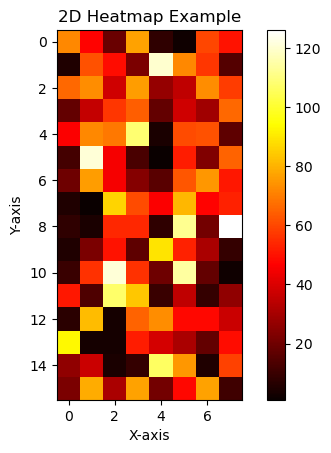

In [20]:
# Create some data
# Create the heatmap
x = error_val.reshape(-1, 8)
plt.imshow(x, cmap='hot', interpolation='nearest')
plt.colorbar()

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Heatmap Example')

# Show the plot
plt.show()


In [21]:
row_size = 128
col_size = 128
redunc_idx = 0
out_val = torch.zeros(size=(row_size, col_size), dtype=torch.int32)
eval_val, precise_val, pre_scale_errs = cal_acim(qin[0:row_size, 128*redunc_idx:128*(redunc_idx+1)], qw.T[128*redunc_idx:128*(redunc_idx+1), 0:col_size], 4, 4, quant=True)
out_val[:, :] += eval_val

In [57]:
pre_scale_errs[0, 2]

[[tensor(1, dtype=torch.int32)],
 [tensor(-1, dtype=torch.int32), tensor(-1, dtype=torch.int32)],
 [tensor(0, dtype=torch.int32),
  tensor(1, dtype=torch.int32),
  tensor(-1, dtype=torch.int32)],
 [tensor(0, dtype=torch.int32),
  tensor(1, dtype=torch.int32),
  tensor(0, dtype=torch.int32),
  tensor(1, dtype=torch.int32)],
 [tensor(0, dtype=torch.int32),
  tensor(0, dtype=torch.int32),
  tensor(0, dtype=torch.int32)],
 [tensor(0, dtype=torch.int32), tensor(-1, dtype=torch.int32)],
 [tensor(0, dtype=torch.int32)]]

In [23]:
ref_val = torch.matmul(qin[0:row_size, 128*redunc_idx:128*(redunc_idx+1)], qw.T[128*redunc_idx:128*(redunc_idx+1), 0:col_size])
err_val_ = torch.abs(out_val - ref_val)
rel_err_val_ = torch.abs(out_val - ref_val) / (torch.abs(ref_val) + 1)

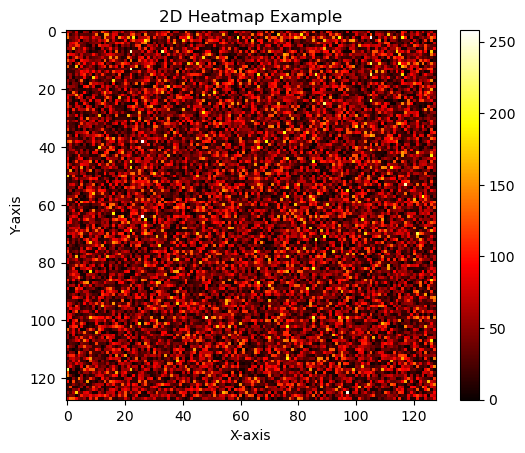

In [24]:
# Create some data
# Create the heatmap
plt.imshow(err_val_, cmap='hot', interpolation='nearest')
plt.colorbar()

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Heatmap Example')

# Show the plot
plt.show()

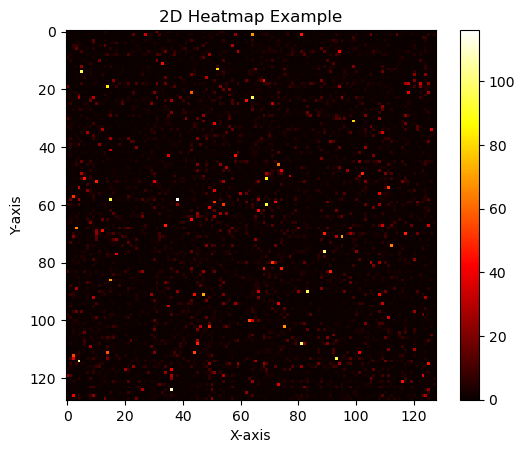

In [25]:
# Create some data
# Create the heatmap
plt.imshow(rel_err_val_, cmap='hot', interpolation='nearest')
plt.colorbar()

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Heatmap Example')

# Show the plot
plt.show()

In [26]:
rel_err_val_.max()

tensor(116.)

In [27]:
max = err_val_.max()
min = err_val_.min()
mean= err_val_.float().mean()
std = err_val_.float().std()
print(f"Max: {max}, Min: {min}, Mean: {mean}, Std: {std}")

Max: 258, Min: 0, Mean: 49.3043212890625, Std: 37.24482345581055


In [28]:
err_val_.flatten().sort()[0].unique()

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 174, 175, 176, 177, 178, 179, 1

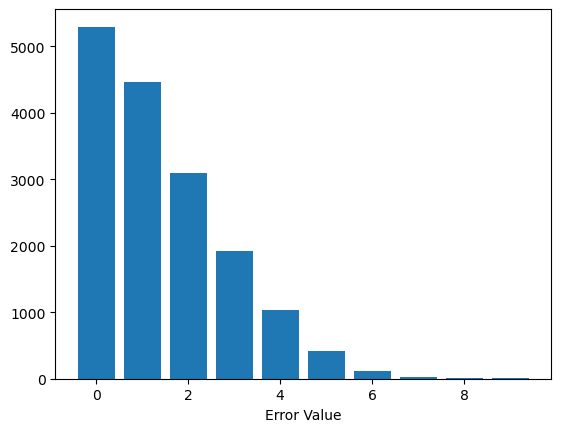

In [29]:
bins = 10
hist = torch.histc(err_val_.float(), bins=bins, min=min, max=max)
x = range(bins)
plt.bar(x, hist, align='center')
plt.xlabel('Error Value')
plt.show()

In [30]:
(err_val_ == 175).nonzero(as_tuple=True)

(tensor([16, 17, 33, 47]), tensor([  9,  16, 100,  22]))

In [31]:
# column 58 -> weight?
err_val_[46, 89]

tensor(21, dtype=torch.int32)

In [32]:
qin[67, 128*redunc_idx:128*(redunc_idx+1)]

tensor([ 0,  0,  0, -1, -1,  1,  1, -1,  0,  0, -1,  0,  1,  2,  1,  1, -1,  0,
         0,  1,  2,  3,  0,  0,  1,  1,  0,  0,  1,  0, -1,  0, -1,  2,  0,  0,
        -5, -2,  3,  3, -1,  1,  0, -1, -2,  0, -2,  0,  2, -1,  0,  1,  3,  1,
         0,  1,  0, -2,  0,  3,  2,  2, -1,  2, -2,  0,  2,  0,  0,  0,  0,  2,
         0,  1, -3,  0,  1,  1,  0,  0,  1, -1, -2,  0, -3, -1,  4,  0, -2,  1,
         0, -1, -1, -1,  1, -3, -3, -8,  0,  1, -1, -2, -1, -1,  0,  3,  0, -4,
        -2,  2,  2,  1, -1, -1, -4,  1, -2,  2, -3, -3, -4,  4, -1, -1,  1,  1,
        -1,  1], dtype=torch.int32)

In [33]:
get_bitplane(qw.T[128*redunc_idx:128*(redunc_idx+1), 89], 2).count_nonzero()

tensor(71)

In [34]:
get_bitplane(qw.T[128*redunc_idx:128*(redunc_idx+1), 90], 2).count_nonzero()

tensor(62)

In [35]:
redunc_idx = 0
row = 46
col = 89
eval_val = cal_acim(qin[row, 128*redunc_idx:128*(redunc_idx+1)], qw.T[128*redunc_idx:128*(redunc_idx+1), col], 4, 4, quant=True)
ref_val = torch.matmul(qin[row, 128*redunc_idx:128*(redunc_idx+1)], qw.T[128*redunc_idx:128*(redunc_idx+1), col])
err_val = torch.abs(out_val - ref_val)

In [36]:
eval_val

(tensor([[-244]], dtype=torch.int32),
 tensor([[-265]], dtype=torch.int32),
 array([[list([[tensor(1, dtype=torch.int32)], [tensor(0, dtype=torch.int32), tensor(-1, dtype=torch.int32)], [tensor(-1, dtype=torch.int32), tensor(-1, dtype=torch.int32), tensor(-1, dtype=torch.int32)], [tensor(0, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(0, dtype=torch.int32), tensor(0, dtype=torch.int32)], [tensor(-2, dtype=torch.int32), tensor(-1, dtype=torch.int32), tensor(0, dtype=torch.int32)], [tensor(0, dtype=torch.int32), tensor(1, dtype=torch.int32)], [tensor(0, dtype=torch.int32)]])]],
       dtype=object))

In [37]:
ref_val

tensor(-265, dtype=torch.int32)

In [38]:
qin[41, 128*redunc_idx:128*(redunc_idx+1)]

tensor([ 0,  2,  1,  3,  0,  2,  0,  1, -5, -1,  0,  0, -2,  2,  1,  1,  0,  2,
         1,  2,  2, -1,  6, -1,  4,  0,  5, -1,  5,  2,  4,  2,  1,  1, -4,  0,
        -1, -8, -2,  2, -1,  0, -2,  2, -3, -2,  0,  1, -4, -1,  0,  2,  2,  1,
        -6, -1,  1,  5,  2,  2,  0,  2,  1,  2, -4,  1,  4,  3,  2, -2,  0,  5,
        -7,  2, -5,  2, -1,  0, -4, -3,  3, -3, -5, -7, -3, -3,  1,  2, -1,  2,
        -5,  0,  4,  0, -1, -4,  2,  0,  1, -1,  2,  2, -1, -1, -4,  1,  1,  0,
        -1,  1, -1,  5, -1,  1,  0, -2, -4,  1, -1, -3, -1, -3,  1, -2,  1,  0,
         1, -3], dtype=torch.int32)

In [39]:
qw.T[128*redunc_idx:128*(redunc_idx+1), 58]

tensor([ 0, -2, -3,  0,  3, -2,  0,  2, -4,  2, -3, -3,  0, -1, -1,  2,  0,  3,
         0,  1, -6, -2, -1, -3,  0,  1, -3,  4,  1,  3,  2,  7, -1, -1,  3, -3,
        -4,  1,  5, -5, -2,  2, -6, -5,  1,  2, -5,  3, -4,  3, -5,  1,  0,  0,
         3, -2, -3,  2, -7, -3, -3, -4, -5, -2,  1,  2,  0, -4, -1,  4, -3,  1,
         7,  2,  4, -1, -2, -3, -1,  1, -5, -2,  1, -5,  2, -2,  2, -4,  3,  1,
        -5, -3, -3, -2, -3,  3,  2,  7, -7, -3,  3,  7,  1,  1, -5, -2,  0,  0,
         6,  2, -3,  2,  1,  1, -2,  2,  6,  0,  0,  7,  2, -2, -1, -1,  0,  1,
         0, -4], dtype=torch.int32)

In [40]:
adaptive_quantize(torch.tensor(27))

tensor(28, dtype=torch.int32)

# Adaptive PSUM quantization trend

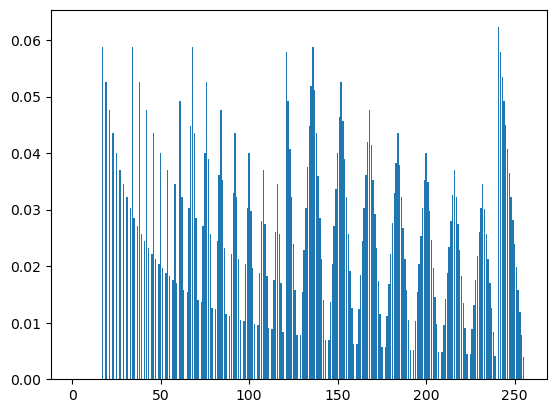

In [55]:
x = torch.arange(1, 256)
y1 = adaptive_quantize(x)
y2 = normal_quantize(x)
err1 = torch.abs(x-y1)/torch.abs(x)
err2 = torch.abs(x-y2)/torch.abs(x)
plt.bar(x, err1, align='center')
plt.show()

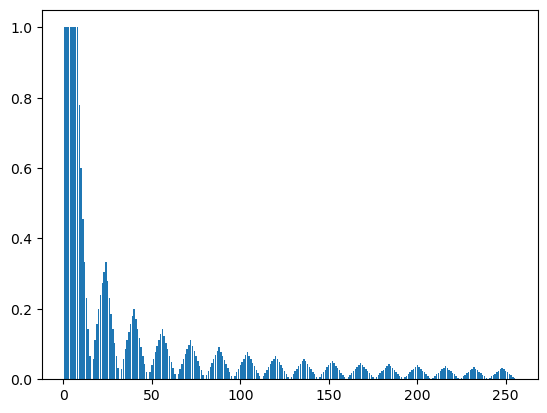

In [54]:
plt.bar(x, err2, align='center')
plt.show()

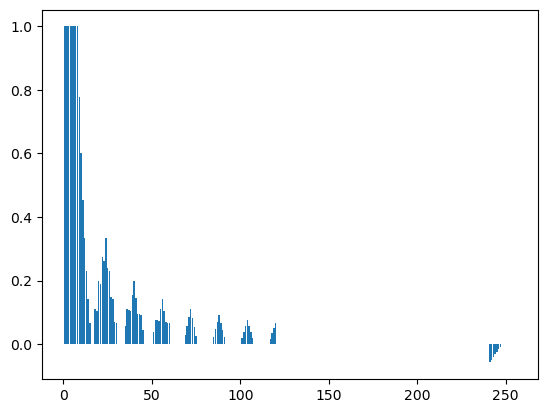

In [53]:
diff = err2 - err1
plt.bar(x, diff, align='center')
plt.show()

# bit scale and error relation analysis

In [58]:
# seq dim, out dim for reduction idx 0
row_size = 128
col_size = 128
redunc_idx = 0
eval_val, precise_val, pre_scale_errs = cal_acim(qin[0:row_size, 128*redunc_idx:128*(redunc_idx+1)], qw.T[128*redunc_idx:128*(redunc_idx+1), 0:col_size], 4, 4, quant=True)

In [61]:
pre_scale_errs

array([[list([[tensor(0, dtype=torch.int32)], [tensor(-1, dtype=torch.int32), tensor(-1, dtype=torch.int32)], [tensor(2, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(0, dtype=torch.int32)], [tensor(-1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(-1, dtype=torch.int32), tensor(-1, dtype=torch.int32)], [tensor(0, dtype=torch.int32), tensor(-1, dtype=torch.int32), tensor(-1, dtype=torch.int32)], [tensor(-2, dtype=torch.int32), tensor(-1, dtype=torch.int32)], [tensor(1, dtype=torch.int32)]]),
        list([[tensor(-1, dtype=torch.int32)], [tensor(-1, dtype=torch.int32), tensor(1, dtype=torch.int32)], [tensor(0, dtype=torch.int32), tensor(0, dtype=torch.int32), tensor(0, dtype=torch.int32)], [tensor(0, dtype=torch.int32), tensor(0, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(-1, dtype=torch.int32)], [tensor(0, dtype=torch.int32), tensor(-1, dtype=torch.int32), tensor(0, dtype=torch.int32)], [tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32)], [

In [99]:
# def get_skewness(data):
#   if isinstance(data, list):
#     data = torch.tensor(data).to(torch.float32)
#   data = data.flatten()
#   mean = data.mean()
#   std = data.std()
#   if data.shape[0] < 3:
#     return None
#   skewness = (((data - mean)/std)**3).sum()*(data.shape[0]/((data.shape[0]-1)*(data.shape[0]-2)))
#   return skewness

def get_skewness(data):
  if isinstance(data, list):
    data = torch.tensor(data).to(torch.float32)
  
  posi_num = data[data > 0].shape[0]
  neg_num = data[data < 0].shape[0]
  return (posi_num, neg_num)

# def get_skewness(data):
#   if isinstance(data, list):
#     data = torch.tensor(data).to(torch.float32)
#   data = data.flatten()
#   mean = data.mean()
#   median = data.median()
#   diff = mean - median
#   return diff

In [100]:
pre_scale_errs[0, 2][3]

[tensor(0, dtype=torch.int32),
 tensor(1, dtype=torch.int32),
 tensor(0, dtype=torch.int32),
 tensor(1, dtype=torch.int32)]

In [110]:
for i in range(7):
  print(get_skewness(pre_scale_errs[0, 6][i]))

(0, 0)
(0, 0)
(0, 1)
(2, 2)
(2, 0)
(0, 1)
(1, 0)
